In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, Bidirectional, LSTM, Dense, Concatenate, Layer, Add, LayerNormalization, Flatten, MaxPooling1D, Dropout, Lambda
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import os
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab_Notebooks"

 06.10.2024-2kernels-maxpooling.ipynb		   saved_model
 1.Data_Preparation_Cleaning.py			   Sentiment_Model_fixed_17.09.24_2classes.ipynb
 2.Data_review.py				   Sentiment_Model.ipynb
 3.Word_embeddings_extration.py			   Sentiment_Model_v2.ipynb
 Archive_data					   test_data_on_10k_no_neutral.csv
 Combine_codes_draft.ipynb			   test_data_on_200_no_neutral.csv
'Copy of 22.10.2024-2kernels-nomaxpooling.ipynb'   test_data_on_500k_no_neutral.csv
'Copy of 30.10.24_add_confusion_matrix.ipynb'	   train_data_on_10k_no_neutral.csv
 Copy_of_Sentiment_Model_fixed_08_09_24.ipynb	   train_data_on_10k_no_neutral.gsheet
 data_three_classes				   train_data_on_200_no_neutral.csv
 Get_1_million_reviews.ipynb			   train_data_on_500k_no_neutral.csv
 Model_anhTuan.py				   train_on_20.csv
 models_new					   two_classes_notcleaned
 neutral_reviews_30.csv				   validation_data_on_10k_no_neutral.csv
 requirements.txt				   validation_data_on_200_no_neutral.csv
 sampled_30_reviews_no_neutral.csv		   validatio

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.query_dense = tf.keras.layers.Dense(self.embed_dim)
        self.key_dense = tf.keras.layers.Dense(self.embed_dim)
        self.value_dense = tf.keras.layers.Dense(self.embed_dim)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        queries = self.query_dense(inputs)
        keys = self.key_dense(inputs)
        values = self.value_dense(inputs)

        attention_scores = tf.matmul(queries, keys, transpose_b=True)
        attention_scores /= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))

        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        attention_output = tf.matmul(attention_weights, values)

        return attention_output

    def get_config(self):
        config = super(SelfAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
        })
        return config

# Define named functions to replace lambda functions
def get_forward_output(x):
    return x[:, :, :256]

def get_backward_output(x):
    return x[:, :, 256:]

def SentimentModel(input_shape=(512, 768)):
    inputs = Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(inputs)
    # maxpool1 = MaxPooling1D(pool_size=2, strides=2)(conv1)

    conv2 = Conv1D(filters=128, kernel_size=4, activation='relu', padding='same')(inputs)
    # maxpool2 = MaxPooling1D(pool_size=2, strides=2)(conv2)

    # Concatenate CNN outputs
    concatenated_cnn = Concatenate(axis=-1)([conv1, conv2])

    # BiLSTM layer
    bilstm_output = Bidirectional(LSTM(256, return_sequences=True))(concatenated_cnn)

    # # Split forward and backward outputs for attention using Lambda layer
    # forward_output = Lambda(lambda x: x[:, :, :256])(bilstm_output)
    # backward_output = Lambda(lambda x: x[:, :, 256:])(bilstm_output)

    # Split forward and backward outputs using named functions in Lambda layers
    forward_output = Lambda(get_forward_output)(bilstm_output)
    backward_output = Lambda(get_backward_output)(bilstm_output)


    # Attention layers
    attention_f = SelfAttention(128)(forward_output)
    attention_b = SelfAttention(128)(backward_output)

    # Concatenate the attention outputs
    concatenated_attention = Concatenate(axis=-1)([attention_f, attention_b])

    # Normalize, flatten, and pass through dense layers
    norm_output = LayerNormalization()(concatenated_attention)
    flattened_output = Flatten()(norm_output)

    dense_1 = Dense(128, activation='relu')(flattened_output)
    dropout_1 = Dropout(0.2)(dense_1)

    dense_2 = Dense(64, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.2)(dense_2)

    outputs = Dense(1, activation='sigmoid')(dropout_2) # Output is a single neuron

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



In [ ]:
# Build the detailed sentiment model
detailed_model = SentimentModel()

# Print the detailed summary
detailed_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 768)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 512, 128)       │        295,040 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 512, 128)       │        393,344 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512, 256)       │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512, 512)       │      1,050,624 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 512, 256)       │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 512, 256)       │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ self_attention            │ (None, 512, 128)       │         98,688 │ lambda[0][0]           │
│ (SelfAttention)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ self_attention_1          │ (None, 512, 128)       │         98,688 │ lambda_1[0][0]         │
│ (SelfAttention)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 512, 256)       │              0 │ self_attention[0][0],  │
│ (Concatenate)             │                        │                │ self_attention_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 512, 256)       │            512 │ concatenate_1[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 131072)         │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │     16,777,344 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)      

 Total params: 18,722,561 (71.42 MB)

 Trainable params: 18,722,561 (71.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Load pre-trained BERT model and tokenizer
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

def bert_embeddings_extraction(reviews):
  input_tokens = bert_tokenizer(reviews, return_tensors='tf', max_length=512, truncation=True, padding='max_length')
  outputs = bert_model(input_tokens)
  embeddings = outputs.last_hidden_state
  return embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def process_and_convert_batch(file_path, batch_size):
  # Second pass to process the data with determined max_length
  for chunk in pd.read_csv(file_path, chunksize=batch_size):
    batch_reviews = chunk['text'].tolist()
    embeddings = bert_embeddings_extraction(batch_reviews)

    # For training/validation with labels
    batch_labels = chunk['label'].astype(int).tolist() # Ensure labels are integer
    y = np.array(batch_labels).reshape(-1, 1)  # Reverse y to shape of (batch_size, 1)

    yield tf.convert_to_tensor(embeddings, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)

In [ ]:
def run_val_test(model, val_file, batch_size, phase='Validation'):
    val_pred_probs = []
    val_true = []
    val_losses = []
    for batch_x, batch_y in process_and_convert_batch(val_file, batch_size):
        val_pred = model.predict(batch_x)
        val_pred_probs.append(val_pred)
        val_true.append(batch_y)
        batch_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(batch_y, val_pred)).numpy()
        val_losses.append(batch_loss)
    val_true = np.concatenate(val_true).flatten()
    val_pred_probs = np.concatenate(val_pred_probs).flatten()
    val_pred_classes = (val_pred_probs >= 0.5).astype(int)

    val_accuracy = np.mean(val_true == val_pred_classes)
    val_precision = precision_score(val_true, val_pred_classes, zero_division=0)
    val_recall = recall_score(val_true, val_pred_classes, zero_division=0)
    val_f1 = f1_score(val_true, val_pred_classes, zero_division=0)
    val_loss = np.mean(val_losses)

    # Calculate confusion matrix
    cm = confusion_matrix(val_true, val_pred_classes, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    # Calculate Specificity and NPV
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Print metrics
    print(f'{phase} Loss: {val_loss:.4f}')
    print(f'{phase} Accuracy: {val_accuracy:.4f}')
    print(f'{phase} Precision: {val_precision:.4f}')
    print(f'{phase} Recall: {val_recall:.4f}')
    print(f'{phase} F1 Score: {val_f1:.4f}')
    print(f'{phase} Specificity: {specificity:.4f}')
    print(f'{phase} Negative Predictive Value (NPV): {npv:.4f}')

    # Print unique values
    print(f"Unique values in val_true: {np.unique(val_true)}")
    print(f"Unique values in val_pred_classes: {np.unique(val_pred_classes)}")

    # Confusion matrix during Testing phase
    if phase == 'Testing':
        print("Confusion Matrix:")
        print(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix - Testing Dataset')
        plt.show()
    return val_accuracy, val_loss, val_precision, val_recall, val_f1, specificity, npv

In [ ]:
def train_and_evaluate(train_file, val_file, test_file, batch_size=128, epochs=2):
    model = SentimentModel()

    # class_weights = [1, 1]
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=Adam(), loss=weighted_categorical_crossentropy(class_weights), metrics=['categorical_accuracy'])

    loss_history_training = []
    accuracy_history_training = []

    loss_history_validation = []
    accuracy_history_validation = []

    precision_history_validation = []
    recall_history_validation = []
    f1_history_validation = []
    specificity_history_validation = []
    npv_history_validation = []

    # Early Stopping Variables
    best_val_loss = float('inf')
    patience = 3
    wait = 0
    best_epoch = 0

    # Define the path to save the models
    model_save_path = '/content/drive/My Drive/Colab_Notebooks/models_new/05_11'
    # Create the directory if it doesn't exist
    os.makedirs(model_save_path, exist_ok=True)

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Training phase
        print(f'Training step at epoch {epoch+1}')
        train_loss, train_accuracy = 0, 0
        num_batches = 0
        for batch_x, batch_y in process_and_convert_batch(train_file, batch_size):
            history = model.fit(batch_x, batch_y, batch_size=batch_size, epochs=1, verbose=0)

            training_loss = history.history['loss'][0]
            training_accuracy = history.history['accuracy'][0]
            # print(training_loss, training_accuracy)
            print(f"Batch Loss: {training_loss:.4f}, Batch Accuracy: {training_accuracy:.4f}")

            train_loss += training_loss
            train_accuracy += training_accuracy
            num_batches += 1
        loss_history_training.append(train_loss / num_batches)
        accuracy_history_training.append(train_accuracy / num_batches)
        print(f'End of Training Epoch {epoch + 1}, Loss: {train_loss/num_batches:.4f}, Accuracy: {train_accuracy/num_batches:.4f}')
        # Save the model to Google Drive
        model_save_filename = os.path.join(model_save_path, f'epoch_{epoch+1}.keras')
        model.save(model_save_filename)
        print(f'Model saved to {model_save_filename}')

        # Validation phase
        print(f'Validation step at epoch {epoch+1}')
        acc, loss, precision, recall, f1, specificity, npv = run_val_test(model, val_file, batch_size)
        loss_history_validation.append(loss)
        accuracy_history_validation.append(acc)
        precision_history_validation.append(precision)
        recall_history_validation.append(recall)
        f1_history_validation.append(f1)
        specificity_history_validation.append(specificity)
        npv_history_validation.append(npv)

        # Early Stopping Logic based on Validation Loss
        if loss < best_val_loss:
            best_val_loss = loss
            wait = 0
            best_epoch = epoch + 1
            # Save the best model
            model_save_filename = os.path.join(model_save_path, f'best_model_epoch_{best_epoch}.keras')
            model.save(model_save_filename)
            print(f'New best model saved at epoch {best_epoch} with validation loss {best_val_loss:.4f}')
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss')
                break

    # Load the best model after training
    best_model = tf.keras.models.load_model(os.path.join(model_save_path, f'best_model_epoch_{best_epoch}.keras'), custom_objects={'SelfAttention': SelfAttention, 'get_forward_output': get_forward_output, 'get_backward_output': get_backward_output})

    # Plot the results for Training phase
    print('----Plot Training metrics')
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss_history_training) + 1), loss_history_training, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracy_history_training) + 1), accuracy_history_training, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()

    plt.show()

    # Plot the results for Validation phase
    print('----Plot Validation metrics')
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(loss_history_validation) + 1), loss_history_validation, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracy_history_validation) + 1), accuracy_history_validation, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.show()

    # Plot Precision, Recall, F1
    plt.figure(figsize=(18, 6))

    # Plot Precision
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(precision_history_validation) + 1), precision_history_validation, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Validation Precision over Epochs')
    plt.legend()

    # Plot Recall
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(recall_history_validation) + 1), recall_history_validation, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Validation Recall over Epochs')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(f1_history_validation) + 1), f1_history_validation, label='Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.title('Validation F1-score over Epochs')
    plt.legend()

    plt.show()

    # Plot Specificity and NPV
    plt.figure(figsize=(12, 5))

    # Plot Specificity
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(specificity_history_validation) + 1), specificity_history_validation, label='Validation Specificity')
    plt.xlabel('Epochs')
    plt.ylabel('Specificity')
    plt.title('Validation Specificity over Epochs')
    plt.legend()

    # Plot NPV
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(npv_history_validation) + 1), npv_history_validation, label='Validation NPV')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Predictive Value (NPV)')
    plt.title('Validation NPV over Epochs')
    plt.legend()

    plt.show()

    # Testing phase
    print(f'Testing step at epoch {best_epoch}')
    run_val_test(best_model, test_file, batch_size, phase='Testing')

Streaming output truncated to the last 5000 lines.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

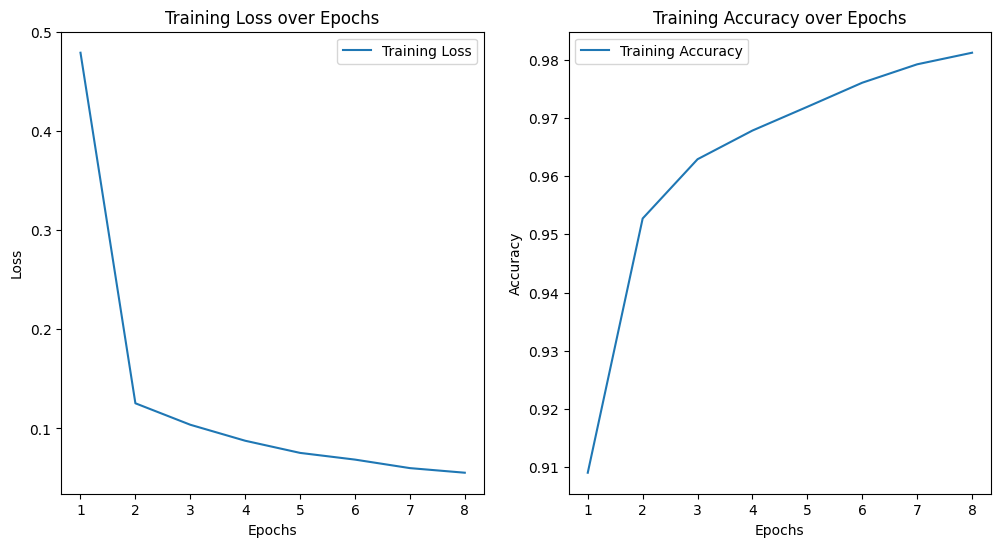

----Plot Validation metrics


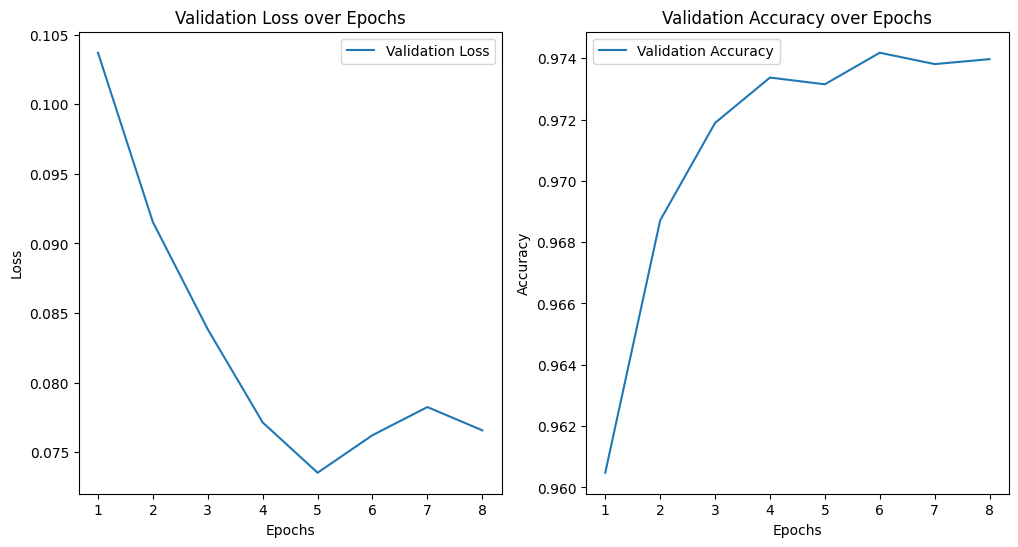

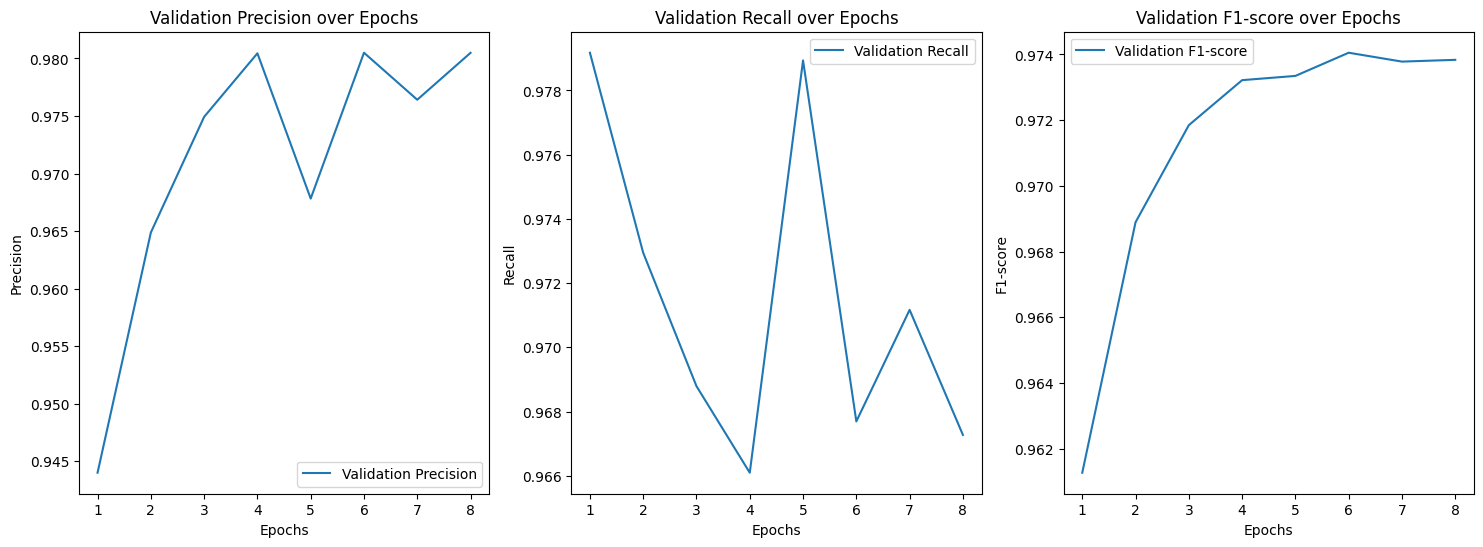

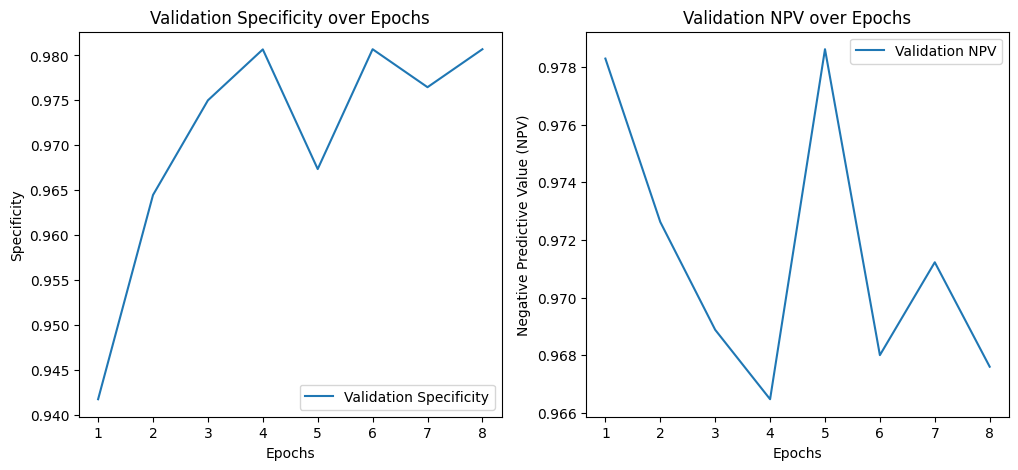

Testing step at epoch 5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0

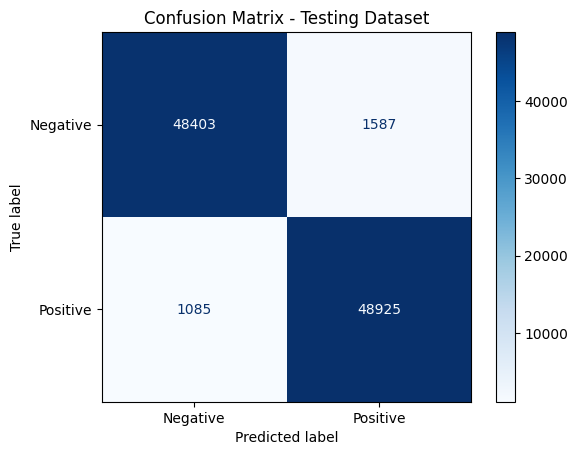

In [ ]:
# Call the function train_and_evaluate
train_and_evaluate('/content/drive/My Drive/Colab_Notebooks/train_data_on_500k_no_neutral.csv', '/content/drive/My Drive/Colab_Notebooks/validation_data_on_500k_no_neutral.csv', '/content/drive/My Drive/Colab_Notebooks/test_data_on_500k_no_neutral.csv', batch_size=256, epochs=20)


In [ ]:
# Function to preprocess and predict new reviews
def predict_new_reviews(model, file_path, batch_size, max_length):
    for chunk in pd.read_csv(file_path, chunksize=batch_size):
        batch_reviews = chunk['text'].tolist()
        truth_labels = chunk['label'].tolist()
        # Call the BERT embeddings extraction and ensure correct tensor conversion
        embeddings_np = bert_embeddings_extraction(batch_reviews)

        # Convert to TensorFlow tensor for model prediction
        processed_reviews = tf.convert_to_tensor(embeddings_np, dtype=tf.float32)
        print(f"Processed reviews shape: {processed_reviews.shape}")  # Debugging statement

        # Use the provided Keras model to predict
        predictions = model.predict(processed_reviews)
        # # Convert probabilities to class labels
        # predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest probability (in case multiclass classification)

        # Convert probabilities to class labels based on a threshold of 0.5
        predicted_labels = (predictions >= 0.5).astype(int)  # 1 if probability >= 0.5, else 0, in Binary_classification

        # # Print predicted labels and corresponding probabilities,
        # for review, truth_label, label, prob in zip(batch_reviews, truth_labels, predicted_labels, predictions):
        #     print(f"Review: '{review}'\n\n\n -> truth_labels: {truth_label}, Predicted Label: {label}, Probabilities: {prob}\n\n")  #(in case multiclass classification)
        for review, truth_label, label, prob in zip(batch_reviews, truth_labels, predicted_labels, predictions.flatten()):
            sentiment = 'Positive' if label == 1 else 'Negative'
            print(f"Review: '{review}'\nTruth Label: {truth_label}, Predicted Label: {label} ({sentiment}), Probability: {prob:.4f}\n")



In [ ]:
import keras

# Enable unsafe deserialization
keras.config.enable_unsafe_deserialization()

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/models_new/05_11/best_model_epoch_5.keras", custom_objects={'SentimentModel': SentimentModel, 'SelfAttention': SelfAttention, 'get_forward_output': get_forward_output, 'get_backward_output': get_backward_output})

predicted_labels = predict_new_reviews(model,'/content/drive/MyDrive/Colab_Notebooks/train_on_20.csv', batch_size=32, max_length=512)



NameError: name 'predict_new_reviews' is not defined

In [ ]:
# Function to predict sentiment classification for a single review
def predict_single_review(model, review, max_length=512):
    # Convert the single review into a list (batch of size 1)
    batch_reviews = [review]

    # Call BERT embeddings extraction function
    embeddings_np = bert_embeddings_extraction(batch_reviews)

     # Use the model to predict the sentiment
    predictions = model.predict(embeddings_np)

    # Convert probabilities to class labels based on a threshold of 0.5
    predicted_label = (predictions >= 0.5).astype(int)  # 1 if probability > 0.5, else 0, in Binary_classification

    # Print predicted labels and corresponding probabilities
    print(f"Review: '{review}'\nPredicted Sentiment: {predicted_label[0][0]} (Probability: {predictions[0][0]:.4f})")


In [ ]:
# Example of predicting sentiment for a single user-input review. Paste another reviews for test in "user_review"
user_review = "My husband and I went to Trattoria Lenas on New Year's Day. It was a disaster. Zero organization. I still haven't figured out how many waiters there were because at some point the guests got up to help serve and clear the table. Una Tarantella!! More seats were sold than were available because people waited 45 minutes for their seats when seats were not there. very cramped, bad food, dishes were brought without clearing away the previous ones. We had to wait almost two hours for drinks! The last course was served 5 minutes before midnight when it was said that the eating would end and the dancing would begin at 10.30pm. I can understand that for a New Year's Eve dinner €98 for adults and €59 for children is more than fair, but if I had known all this I would never have come! The panna cotta was so hard we could use it as fireworks. It was a disappointment"
import keras

# Enable unsafe deserialization
keras.config.enable_unsafe_deserialization()

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/models_new/05_11/best_model_epoch_5.keras", custom_objects={'SentimentModel': SentimentModel, 'SelfAttention': SelfAttention, 'get_forward_output': get_forward_output, 'get_backward_output': get_backward_output})

predict_single_review(model, user_review, max_length=512)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Review: 'My husband and I went to Trattoria Lenas on New Year's Day. It was a disaster. Zero organization. I still haven't figured out how many waiters there were because at some point the guests got up to help serve and clear the table. Una Tarantella!! More seats were sold than were available because people waited 45 minutes for their seats when seats were not there. very cramped, bad food, dishes were brought without clearing away the previous ones. We had to wait almost two hours for drinks! The last course was served 5 minutes before midnight when it was said that the eating would end and the dancing would begin at 10.30pm. I can understand that for a New Year's Eve dinner €98 for adults and €59 for children is more than fair, but if I had known all this I would never have come! The panna cotta was so hard we could use it as fireworks. It was a disappointment'
Predicted Sentiment: 0 (Probability: 0.0022)


In [ ]:
user_review = "It was such a lucky day, when I have to line up for a several hours"

import keras

# Enable unsafe deserialization
keras.config.enable_unsafe_deserialization()

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/models_new/05_11/best_model_epoch_5.keras", custom_objects={'SentimentModel': SentimentModel, 'SelfAttention': SelfAttention, 'get_forward_output': get_forward_output, 'get_backward_output': get_backward_output})

predict_single_review(model, user_review, max_length=512)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Review: 'It was such a lucky day, when I have to line up for a several hours'
Predicted Sentiment: 0 (Probability: 0.4300)
